# Quickstart (Detailed)

Based on the tutorial: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

This notebook is almost the same as the [quickstart.ipynb](./quickstart.ipynb) notebook, but it includes custom handlers to demonstrate different ways the manager can be customized.

It defines a class `MyMetricsHandler`, which is responsible for collecting custom metrics during the training process. This handler can be used to track additional metrics beyond the default ones provided by the manager (loss, accuracy and time).

It also defines a class `MyMetrics` to plot custom graphs after the training is complete. An interesting aspect is that it can use the custom metrics calculated during the training by `MyMetricsHandler`. For example, you can see plots of the correct and incorrect labels, revealing that the `Shirt` category has the highest number of incorrect predictions. In contrast, the `Sandal` category initially performed poorly but showed significant improvement over the epochs.

Functions `get_batch_info` and `get_epoch_info` are defined to print custom information during the training, instead of the default output. These functions can also retrieve and print the custom metrics.

At the end, a custom evaluator `MyDebugEvaluator` is created. This evaluator works similarly to the main evaluator used when calling `manager.evaluate(input)`, but it is passed to the `debug` method of the manager (which expects an evaluator along with the input). The `debug` method is essentially like the `evaluate` method, but instead of using the main evaluator defined when creating the manager, it can use any other evaluator you define. This can be useful for debugging a model, processing it differently (possibly with less performance) to find errors or understand the patterns it has learned about the data, without using this method by default.

In the example of this notebook, the `debug` method shows an image of the SHAP values found when processing an image from the dataset. It correctly identifies a pullover, and you can see that the first image is the input, while the other 10 images represent the patterns the model considered when determining the probabilities of each category. The image with more pink and less blue has the highest probability, which in this case was the third image, corresponding to a pullover.

### Working with data

In [14]:
NAME = 'quickstart_detailed'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'

In [15]:
import sys
if "../" not in sys.path:
  sys.path.append("../")

In [16]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')
warnings.filterwarnings('ignore', category=UserWarning, message='unrecognized nn.Module: Flatten')

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [18]:
# Download training data from open datasets.
full_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [19]:
# divide the training data into training and validation data (80/20)
from torch.utils.data import Subset
data_list = [d for d in full_training_data]
amount = len(data_list)
training_data = Subset(full_training_data, list(range(int(amount*0.8))))
validation_data = Subset(full_training_data, list(range(int(amount*0.8), amount)))

In [20]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"[train] Shape of X [N, C, H, W]: {X.shape}")
    print(f"[train] Shape of y: {y.shape} {y.dtype}")
    break

for X, y in test_dataloader:
    print(f"[test ] Shape of X [N, C, H, W]: {X.shape}")
    print(f"[test ] Shape of y: {y.shape} {y.dtype}")
    break

[train] Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
[train] Shape of y: torch.Size([64]) torch.int64
[test ] Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
[test ] Shape of y: torch.Size([64]) torch.int64


### Creating Models

In [21]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Creating the manager

In [22]:
import typing
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from auto_mind.supervised.data import TrainEpochInfo, TrainBatchInfo, MinimalFullState
from auto_mind.supervised.handlers import TensorMetricsHandler, MetricsHandlerInput
from src.lib.metrics import MetricsItemPlotter, MetricsCalculatorParams

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

class MyMetricsHandler(TensorMetricsHandler[dict[str, typing.Any]]):
    def define(self, data: MetricsHandlerInput) -> dict[str, typing.Any]:
        amount = data.amount
        loss = data.loss
        accuracy = data.accuracy
        output = data.output
        target = data.target
        correct_labels: dict[int, int] = dict()
        wrong_labels: dict[int, int] = dict()

        if output is not None and target is not None:
            _, predicted = torch.max(output, 1)
            for i in range(len(predicted)):
                correct = bool((predicted[i] == target[i]).item())
                idx = int(target[i].item())

                if correct:
                    if idx not in correct_labels:
                        correct_labels[idx] = 0
                    correct_labels[idx] += 1
                else:
                    if idx not in wrong_labels:
                        wrong_labels[idx] = 0
                    wrong_labels[idx] += 1

        return dict(
            amount=amount,
            loss=loss/amount if amount > 0 else 0,
            accuracy=accuracy,
            correct_labels=correct_labels,
            wrong_labels=wrong_labels,
        )

    def add(self, current: dict[str, typing.Any] | None, metrics: dict[str, typing.Any]):
        current = current or dict(amount=0, total_loss=0, total_accuracy=0)

        current_amount = current.get('amount', 0)
        current_loss = current.get('loss', 0)
        current_accuracy = current.get('accuracy', 0)

        new_amount = metrics.get('amount', 0)
        new_loss = metrics.get('loss', 0)
        new_accuracy = metrics.get('accuracy', 0)

        current_weight = current_amount / (current_amount + new_amount)
        new_weight = 1 - current_weight

        amount = current_amount + new_amount
        loss = (current_weight * current_loss + new_weight * new_loss) if amount > 0 else 0
        accuracy = (current_weight * current_accuracy + new_weight * new_accuracy) if amount > 0 else 0

        correct_labels = current.get('correct_labels', dict())
        wrong_labels = current.get('wrong_labels', dict())

        for k, v in metrics.get('correct_labels', {}).items():
            if k not in correct_labels:
                correct_labels[k] = 0
            correct_labels[k] += v

        for k, v in metrics.get('wrong_labels', {}).items():
            if k not in wrong_labels:
                wrong_labels[k] = 0
            wrong_labels[k] += v

        return dict(
            amount=amount,
            loss=loss,
            accuracy=accuracy,
            correct_labels=correct_labels,
            wrong_labels=wrong_labels,
        )

    @classmethod
    def describe(cls, metrics: dict[str, int | float]):
        amount = metrics.get('amount', 0)
        loss = metrics.get('loss', 0)
        accuracy = metrics.get('accuracy', 0)

        amount_str = f'amount={amount}'
        accuracy_str = f'accuracy={100*accuracy:.2f}%'
        loss_str = f'loss={loss:.4f}'

        return f'{amount_str}, {accuracy_str}, {loss_str}'

class MyMetrics(MetricsItemPlotter[dict[str, None]]):
    def __init__(self, name: str):
        super().__init__(name=name)

    def run(self, params: MetricsCalculatorParams) -> dict[str, None]:
        return dict()

    def plot(self, info: MinimalFullState, metric: dict[str, None], figsize: tuple[float, float] | None) -> list[Figure]:
        train_metrics: list[tuple[int, typing.Any]] | None = info.train_results.metrics
        val_metrics: list[tuple[int, typing.Any]] | None = info.train_results.val_metrics
        fig: Figure | None = None

        if train_metrics is not None:
            train_amounts: list[tuple[int, float]] = [(epoch, metric.get('amount', 0)) for epoch, metric in train_metrics]
            train_losses: list[tuple[int, float]] = [(epoch, metric.get('loss', 0)) for epoch, metric in train_metrics]
            train_accuracies: list[tuple[int, float]] | None = [(epoch, metric.get('accuracy', 0)) for epoch, metric in train_metrics]
            train_correct_labels: list[tuple[int, dict[int, int]]] = [(epoch, metric.get('correct_labels', {})) for epoch, metric in train_metrics]
            train_wrong_labels: list[tuple[int, dict[int, int]]] = [(epoch, metric.get('wrong_labels', {})) for epoch, metric in train_metrics]

            val_amounts: list[tuple[int, float]] | None = [(epoch, metric.get('amount', 0)) for epoch, metric in val_metrics] if val_metrics else None
            val_losses: list[tuple[int, float]] | None = [(epoch, metric.get('loss', 0)) for epoch, metric in val_metrics] if val_metrics else None
            val_accuracies: list[tuple[int, float]] | None = [(epoch, metric.get('accuracy', 0)) for epoch, metric in val_metrics] if val_metrics else None
            val_correct_labels: list[tuple[int, dict[int, int]]] | None = [(epoch, metric.get('correct_labels', {})) for epoch, metric in val_metrics] if val_metrics else None
            val_wrong_labels: list[tuple[int, dict[int, int]]] | None = [(epoch, metric.get('wrong_labels', {})) for epoch, metric in val_metrics] if val_metrics else None

            if train_losses and train_accuracies:
                fig, ax_untyped = plt.subplots(nrows=7, ncols=1, figsize=(16, 16))
                fig.tight_layout()
                ax = typing.cast(np.ndarray, ax_untyped)
                ax1: Axes = ax[0]
                ax2: Axes = ax[1]
                ax3: Axes = ax[2]
                ax4: Axes = ax[3]
                ax5: Axes = ax[4]
                ax6: Axes = ax[5]
                ax7: Axes = ax[6]

                epochs = [epoch for epoch, _ in train_amounts]
                amounts = [amount for _, amount in train_amounts]
                ax1.plot(epochs, amounts, '-', label='Train Amounts')
                if val_amounts and len(val_amounts) == len(epochs):
                    epochs = [epoch for epoch, _ in val_amounts]
                    amounts = [amount for _, amount in val_amounts]
                    ax1.plot(epochs, amounts, '-', label='Validation Amounts')

                epochs = [epoch for epoch, _ in train_losses]
                losses = [loss for _, loss in train_losses]
                ax2.plot(epochs, losses, '-', label='Train Loss')
                if val_losses and len(val_losses) == len(epochs):
                    epochs = [epoch for epoch, _ in val_losses]
                    losses = [loss for _, loss in val_losses]
                    ax2.plot(epochs, losses, '-', label='Validation Loss')

                epochs = [epoch for epoch, _ in train_accuracies]
                accuracies = [accuracy for _, accuracy in train_accuracies]
                ax3.plot(epochs, accuracies, '-', label='Train Accuracy')
                if val_accuracies and len(val_accuracies) == len(epochs):
                    epochs = [epoch for epoch, _ in val_accuracies]
                    accuracies = [accuracy for _, accuracy in val_accuracies]
                    ax3.plot(epochs, accuracies, '-', label='Validation Accuracy')

                epochs = [epoch for epoch, _ in train_correct_labels]
                correct_labels = [correct_labels for _, correct_labels in train_correct_labels]
                all_keys = sorted(list(set([k for d in correct_labels for k in d.keys()])))
                for key in all_keys:
                    values = [d.get(key, 0) for d in correct_labels]
                    ax4.plot(epochs, values, '-', label=classes[key])

                if val_correct_labels:
                    epochs = [epoch for epoch, _ in val_correct_labels]
                    correct_labels = [correct_labels for _, correct_labels in val_correct_labels]
                    all_keys = sorted(list(set([k for d in correct_labels for k in d.keys()])))
                    for key in all_keys:
                        values = [d.get(key, 0) for d in correct_labels]
                        ax5.plot(epochs, values, '-', label=classes[key])

                epochs = [epoch for epoch, _ in train_wrong_labels]
                wrong_labels = [wrong_labels for _, wrong_labels in train_wrong_labels]
                all_keys = sorted(list(set([k for d in wrong_labels for k in d.keys()])))
                for key in all_keys:
                    values = [d.get(key, 0) for d in wrong_labels]
                    ax6.plot(epochs, values, '-', label=classes[key])

                if val_wrong_labels:
                    epochs = [epoch for epoch, _ in val_wrong_labels]
                    wrong_labels = [wrong_labels for _, wrong_labels in val_wrong_labels]
                    all_keys = sorted(list(set([k for d in wrong_labels for k in d.keys()])))
                    for key in all_keys:
                        values = [d.get(key, 0) for d in wrong_labels]
                        ax7.plot(epochs, values, '-', label=classes[key])

                test_accuracy = info.test_results.accuracy if info.test_results else None
                info_accuracy = f' - Accuracy: {(test_accuracy*100):.2f}%' if test_accuracy else ''

                ax1.set_title(f'[{self.name}] My Metrics{info_accuracy}')
                ax1.set_ylabel('Amounts')
                ax2.set_ylabel('Loss')
                ax3.set_ylabel('Accuracy')
                ax4.set_ylabel('Correct Labels (Train)')
                ax5.set_ylabel('Correct Labels (Validation)')
                ax6.set_ylabel('Wrong Labels (Train)')
                ax7.set_ylabel('Wrong Labels (Validation)')

                for ax_item in ax:
                    ax_typed: Axes = ax_item
                    ax_typed.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        return [fig] if fig else []

def _as_minutes(s: float, spaces: int | None = None):
    m = math.floor(s / 60)
    s -= m * 60
    info = f'{m:.0f}m {s:02.2f}s'
    return f'{info:>{spaces}}' if spaces else info

def _time_since(since: float, percent: float, spaces: int | None = None):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    passed = _as_minutes(s, spaces=spaces)
    remaining = _as_minutes(rs, spaces=spaces)
    return f'{passed} (- {remaining})'

def get_batch_info(info: TrainBatchInfo[dict[str, int | float]]):
    print_loss = info.loss or 0
    print_accuracy = info.accuracy or 0
    print_count = info.count or 1
    batch = info.batch or 0
    total_batch = info.total_batch
    start = info.start or time.time()
    print_prefix = info.prefix or ''
    metrics = info.metrics

    loss_avg = f'{(print_loss / print_count):.4f}'
    loss_avg = f'[loss: {loss_avg}]'

    acc_str = f'{100.0 * print_accuracy / print_count:>5.1f}%'
    acc_str = f'[accuracy: {acc_str}]'

    batch_cap = 10 if total_batch is None else math.ceil(math.log10(total_batch))
    batch_main_str = f'{batch:>{batch_cap}}'
    batch_str = f'<batch: {batch_main_str}>' if total_batch is None else (
        f'<batch: {batch_main_str}/{total_batch}>')
    now = time.time()
    diff_time = now - start
    time_str = _as_minutes(diff_time, spaces=11)
    time_str = f'<{time_str}>'

    metrics_str = MyMetricsHandler.describe(metrics) if metrics else ''
    metrics_str = f' [metrics: {metrics_str}]' if metrics_str else ''

    result = f'{print_prefix}{batch_str} {time_str} {acc_str} {loss_avg}{metrics_str}'

    return result

def get_epoch_info(info: TrainEpochInfo[dict[str, int | float]]):
    epochs = info.epochs or 0
    epoch = info.epoch or 0
    start_epoch = info.start_epoch or 0
    start = info.start or time.time()
    loss = info.loss or 0
    val_loss = info.val_loss or 0
    accuracy = info.accuracy or 0
    val_accuracy = info.val_accuracy or 0
    count = info.count or 1
    validate = info.validate
    metrics = info.metrics

    train_loss_avg = loss / count
    val_loss_avg = val_loss / count
    loss_avg = (
        f'[val_loss: {val_loss_avg:.4f}, train_loss: {train_loss_avg:.4f}]'
        if validate
        else f'[loss: {train_loss_avg:.4f}]')

    train_acc_str = f'{100.0 * accuracy / count:>5.1f}%'
    val_acc_str = f'{100.0 * val_accuracy / count:>5.1f}%'
    acc_str = (
        f'[val_accuracy: {val_acc_str}, train_accuracy: {train_acc_str}]'
        if validate
        else f'[accuracy: {train_acc_str}]')

    metrics_str = MyMetricsHandler.describe(metrics) if metrics else ''
    metrics_str = f' [metrics: {metrics_str}]' if metrics_str else ''

    epoch_cap = math.ceil(math.log10(epochs))
    epoch_str = f'[epoch] {epoch:>{epoch_cap}} {(100.0 * epoch / epochs):>5.1f}%'
    time_str = _time_since(start, (epoch - start_epoch + 1) / (epochs - start_epoch + 1), spaces=11)
    time_str = f'<{time_str}>'
    result = f'{epoch_str} {time_str} {acc_str} {loss_avg} [count: {count}]{metrics_str}'

    return result

In [23]:
from auto_mind import supervised
from auto_mind.supervised.handlers import (
    AccuracyEarlyStopper, GeneralBatchExecutor, MaxProbEvaluator, GeneralBatchAccuracyCalculator)
from auto_mind.supervised.data import DatasetGroup
from src.lib.metrics import (
    MetricsListPlotter, MainMetrics, DatasetsAmountsMetrics, DatasetsCategoricLabelsMetrics,
    TruePredictedClassMetrics, MetricsFileDirectPlotter)

datasets = DatasetGroup(
    train=training_data,
    validation=validation_data,
    test=test_data,
)

manager = supervised.Manager(
    data_params=supervised.ManagerDataParams(
        train_dataloader=train_dataloader,
        validation_dataloader=validation_dataloader,
        test_dataloader=test_dataloader,
    ),
    model_params=supervised.ManagerModelParams(
        model=model,
        criterion=nn.CrossEntropyLoss(),
        executor=GeneralBatchExecutor(),
        use_best=False,
    ),
    optimizer_params=supervised.ManagerOptimizerParams(
        optimizer=torch.optim.SGD(model.parameters(), lr=1e-3),
        scheduler=None,
        train_early_stopper=AccuracyEarlyStopper(min_accuracy=0.9999, patience=20),
        test_early_stopper=None,
    ),
    metrics_params=supervised.ManagerMetricsParams(
        evaluator=MaxProbEvaluator(executor=GeneralBatchExecutor()),
        accuracy_calculator=GeneralBatchAccuracyCalculator(),
        train_metrics_handler=MyMetricsHandler(),
        metrics_calculator=MetricsFileDirectPlotter(
            plotter=MetricsListPlotter(items=[
                MainMetrics(name=NAME),
                MyMetrics(name=f"{NAME}_my_metrics"),
                DatasetsAmountsMetrics(name=f"{NAME}_records", datasets=datasets),
                DatasetsCategoricLabelsMetrics(name=f"{NAME}_status", categories=classes, datasets=datasets),
                TruePredictedClassMetrics(
                    name=f"{NAME}_true_predicted", categories=classes, dataset=datasets.validation
                ) if datasets.validation is not None else None,
            ]),
            file_path=REPORT_PATH,
            figsize=(8, 8),
        ),
        batch_interval=True,
        save_every=20,
        print_every=100,
        metric_every=20,
        get_epoch_info=get_epoch_info,
        get_batch_info=get_batch_info,
    ),
    config=supervised.ManagerConfig(
        save_path=SAVE_PATH,
        random_seed=0,
        train_hook=None,
    ),
)

### Training and Metrics

Starting training for 25 epochs...
> [train] [epoch 1 (  4.0%)] <batch: 100/750> <   0m 1.16s> [accuracy:  11.6%] [loss: 0.0360] [metrics: amount=6400, accuracy=11.59%, loss=0.0360]
> [train] [epoch 1 (  4.0%)] <batch: 200/750> <   0m 2.27s> [accuracy:  16.6%] [loss: 0.0358] [metrics: amount=6400, accuracy=16.61%, loss=0.0358]
> [train] [epoch 1 (  4.0%)] <batch: 300/750> <   0m 3.33s> [accuracy:  24.5%] [loss: 0.0356] [metrics: amount=6400, accuracy=24.45%, loss=0.0356]
> [train] [epoch 1 (  4.0%)] <batch: 400/750> <   0m 4.44s> [accuracy:  30.0%] [loss: 0.0354] [metrics: amount=6400, accuracy=30.05%, loss=0.0354]
> [train] [epoch 1 (  4.0%)] <batch: 500/750> <   0m 5.47s> [accuracy:  34.1%] [loss: 0.0352] [metrics: amount=6400, accuracy=34.06%, loss=0.0352]
> [train] [epoch 1 (  4.0%)] <batch: 600/750> <   0m 6.53s> [accuracy:  37.6%] [loss: 0.0350] [metrics: amount=6400, accuracy=37.58%, loss=0.0350]
> [train] [epoch 1 (  4.0%)] <batch: 700/750> <   0m 7.54s> [accuracy:  41.1%] [los

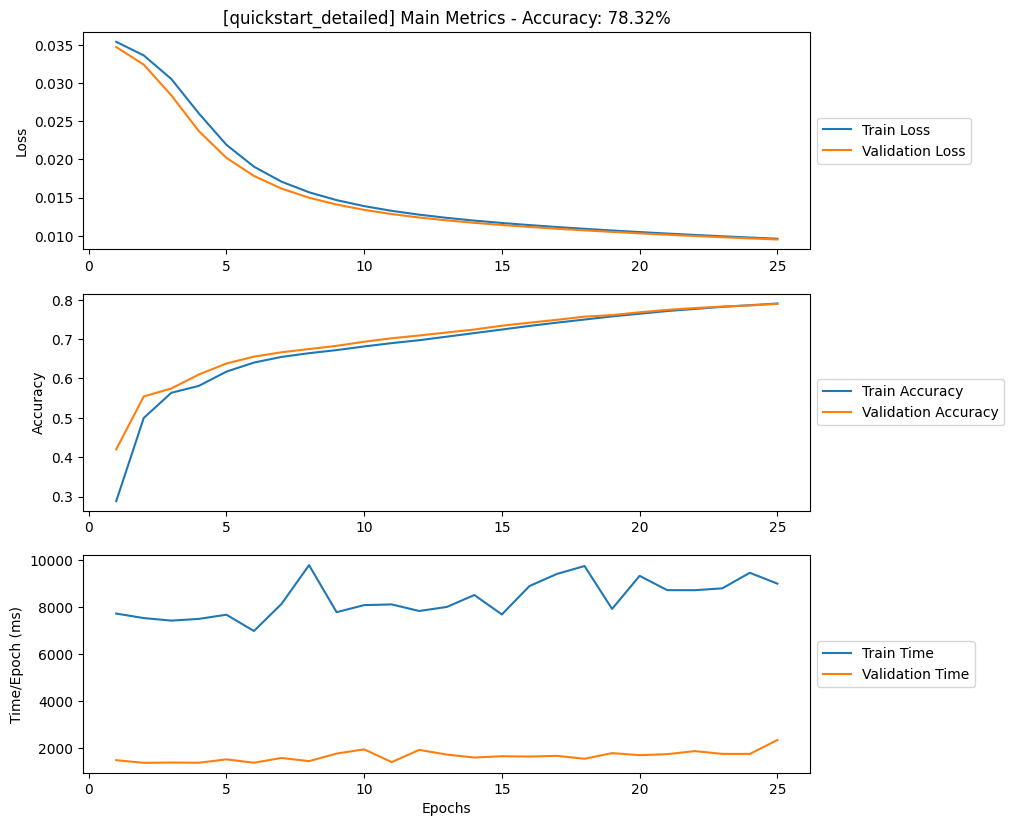

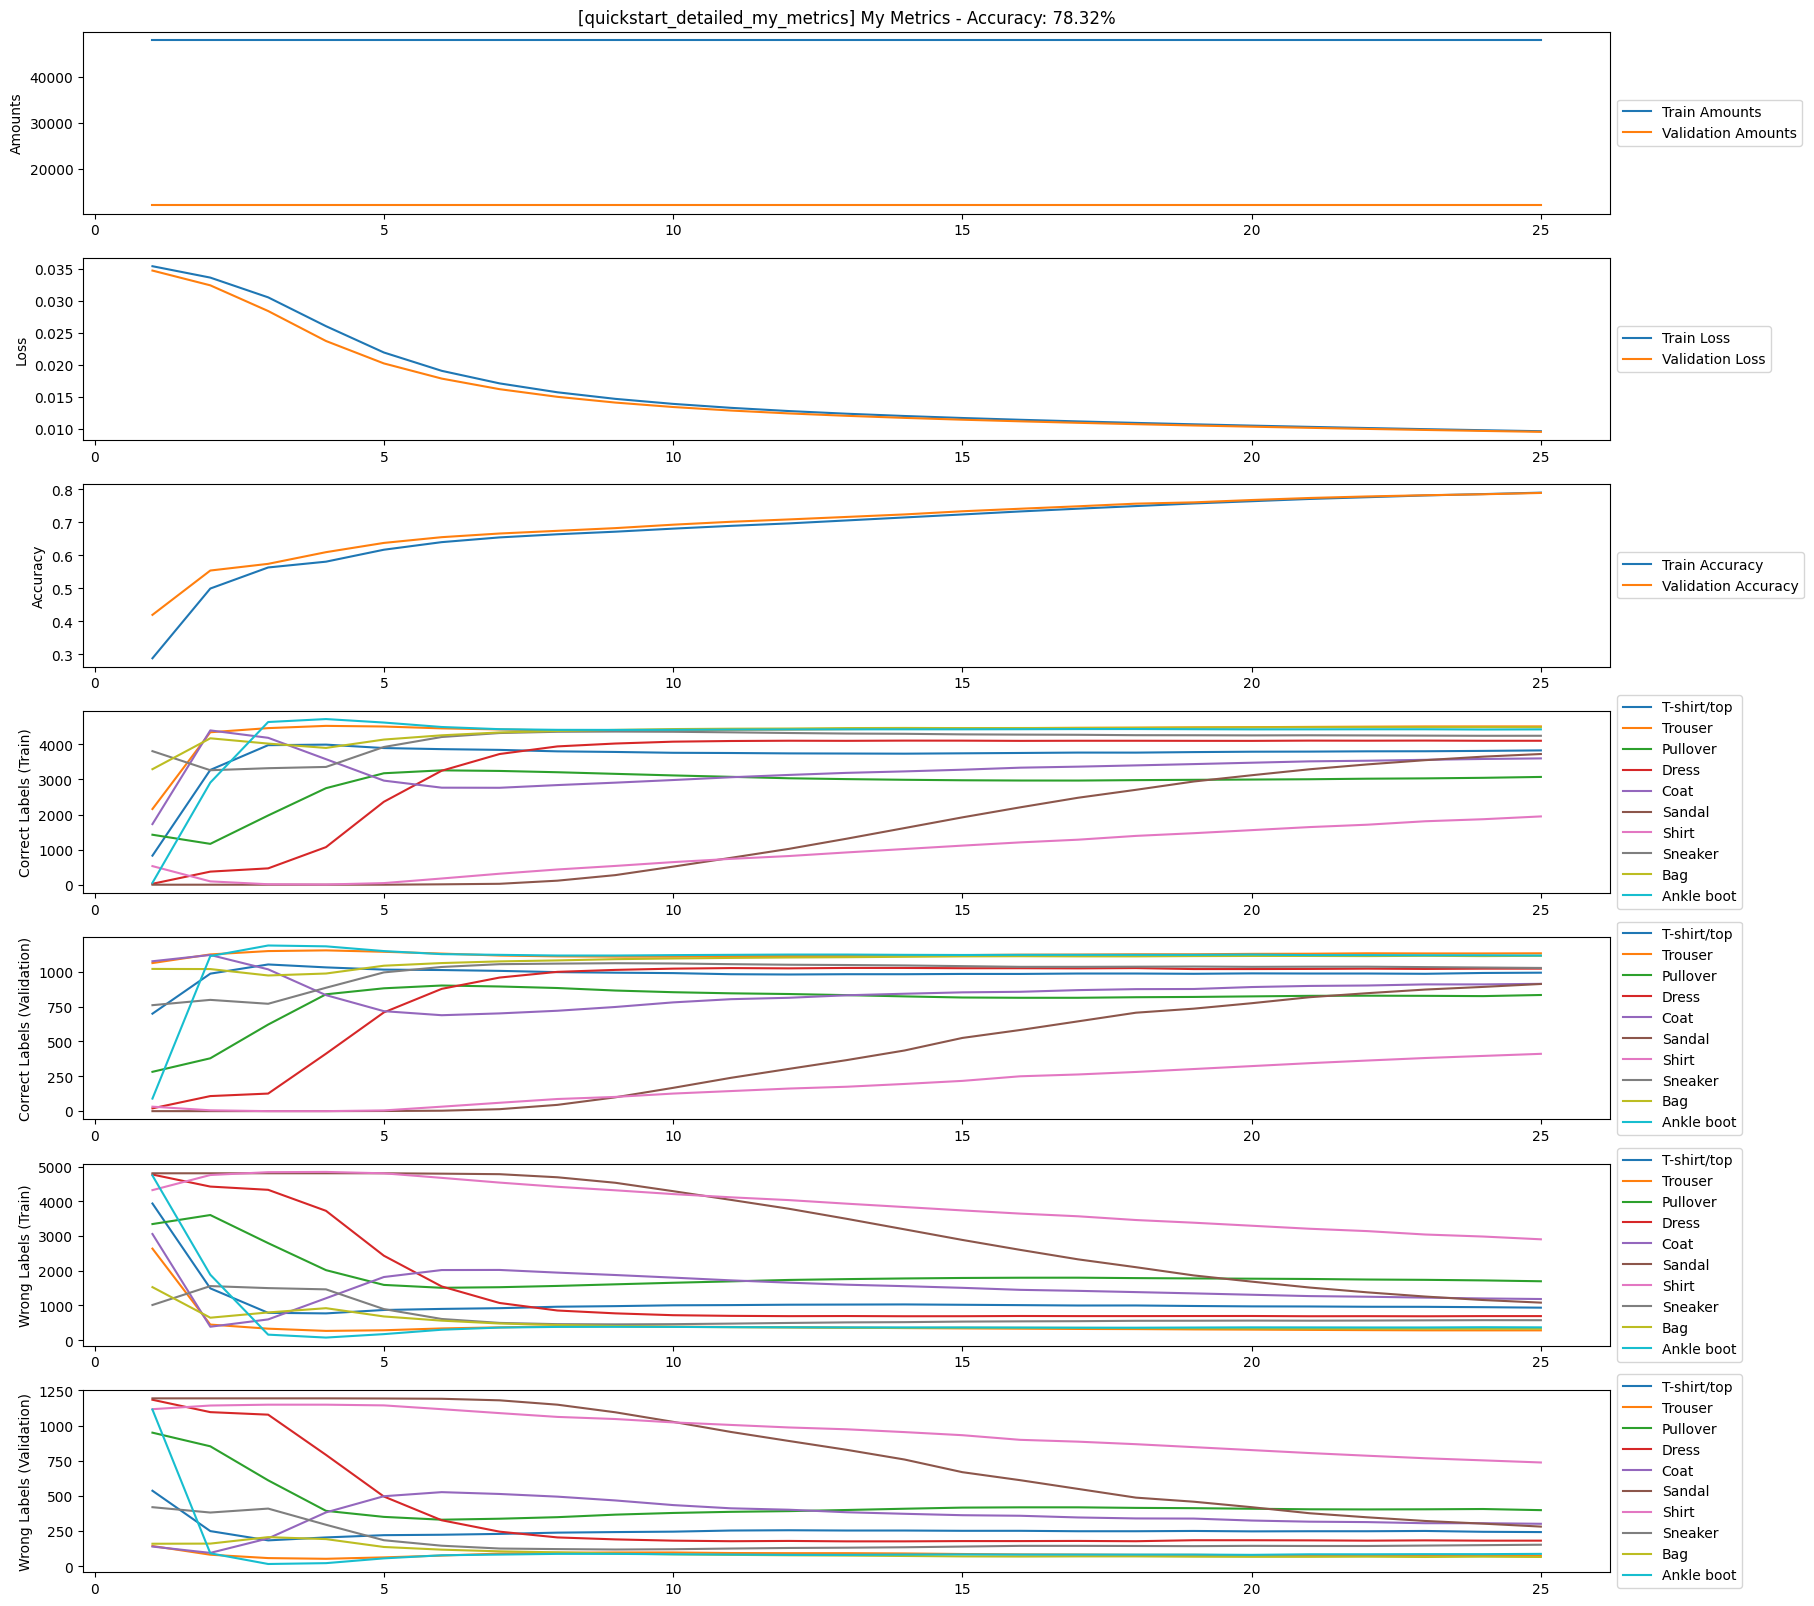

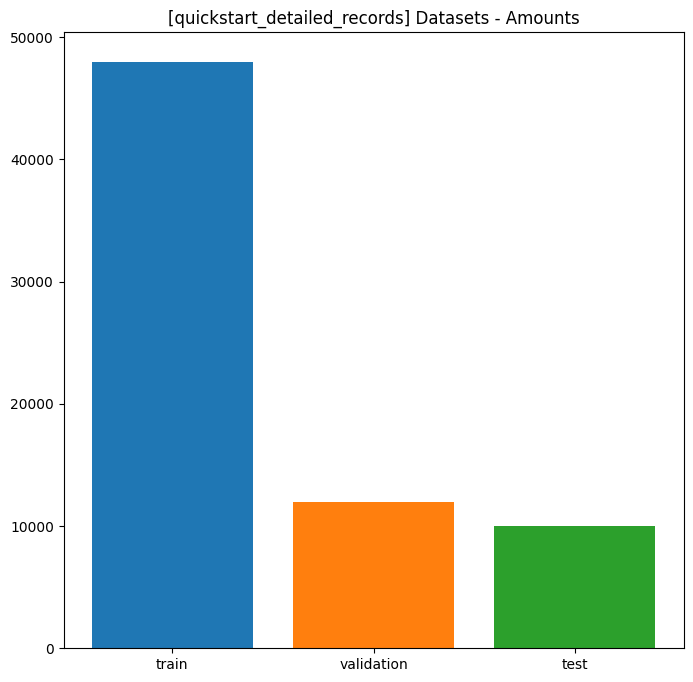

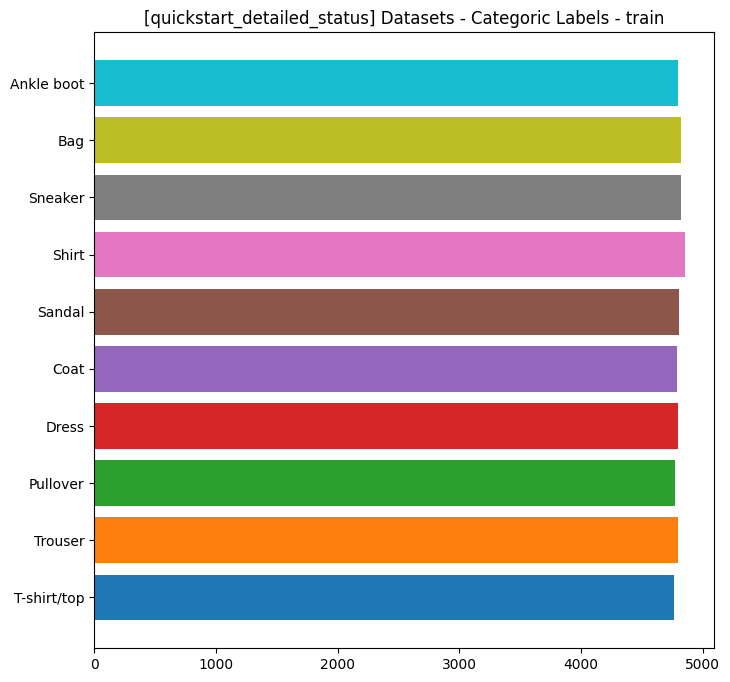

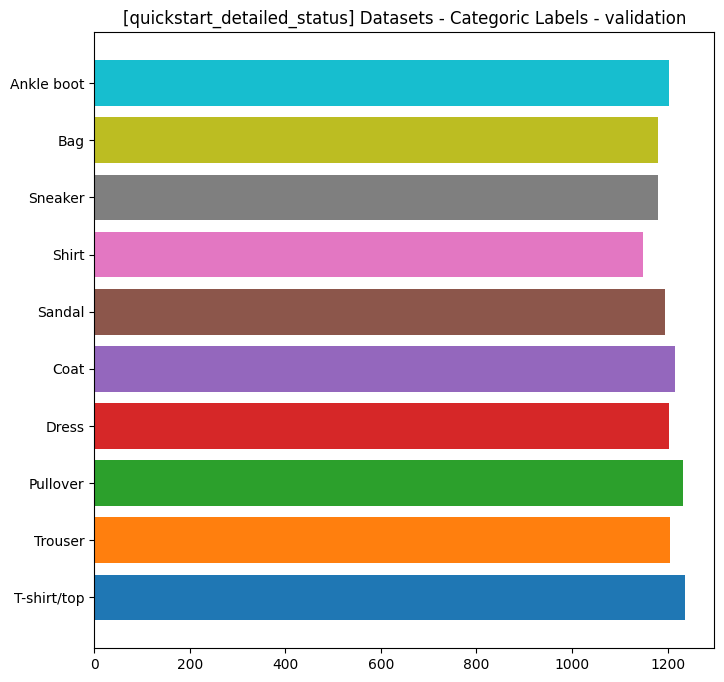

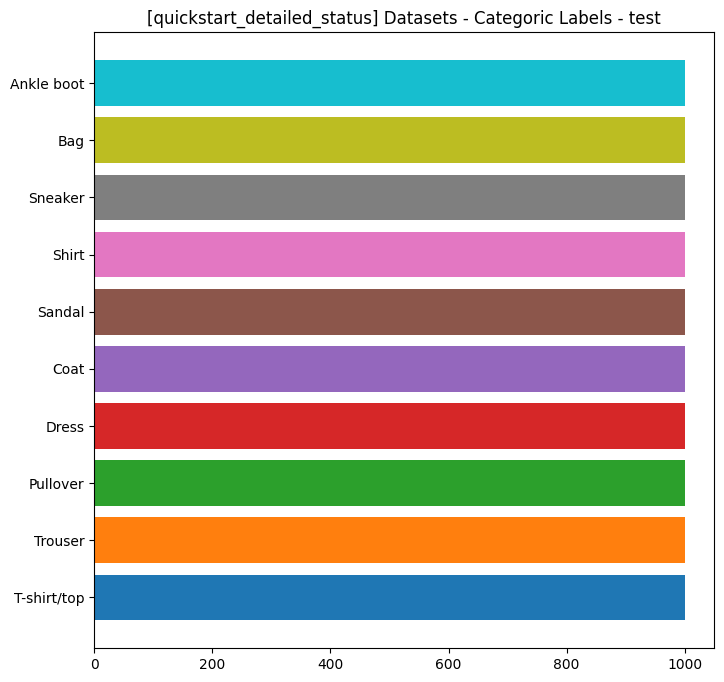

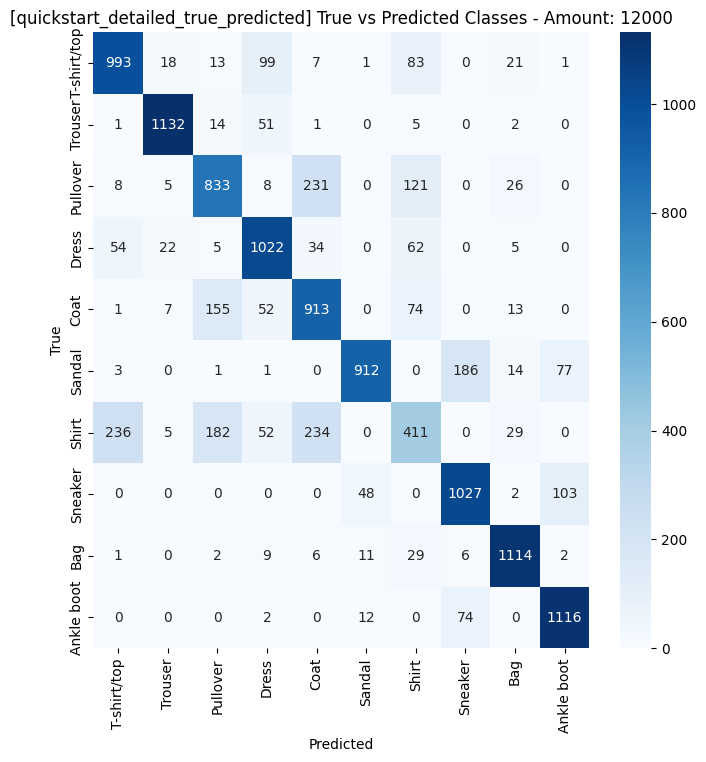

In [24]:
manager.train(epochs=25)

### Making Predictions

In [25]:
x, y = test_data[0][0], test_data[0][1]
result = manager.evaluate(x)
confidence, label = result.prediction
predicted, actual = classes[label], classes[y]
print(f"Predicted: '{predicted}', Actual: '{actual}'")

Predicted: 'Ankle boot', Actual: 'Ankle boot'


Predicted: 'Pullover', Actual: 'Pullover'


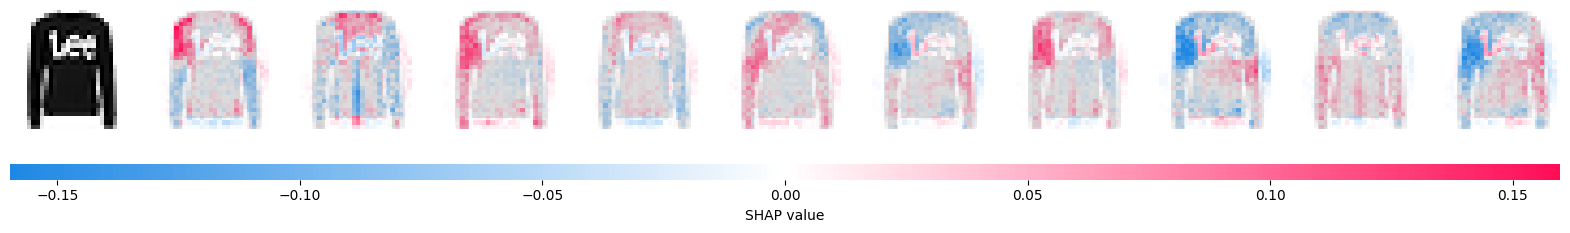

In [26]:
import shap
from auto_mind.supervised.data import GeneralEvalResult
from auto_mind.supervised.handlers import Evaluator

DebugResult = tuple[GeneralEvalResult[torch.Tensor, tuple[float, int]], typing.Any]

class MyDebugEvaluator(Evaluator[torch.Tensor, DebugResult]):
    def run(self, params) -> DebugResult:
        input = params.input
        output = manager.evaluate(input)

        train_data = datasets.limit(100).train
        background = torch.stack([x for x, _ in train_data])
        test_images = input.unsqueeze(0)

        with torch.set_grad_enabled(True):
            e = shap.DeepExplainer(model, background)
            shap_values = e.shap_values(test_images)

        return output, shap_values

x, y = test_data[1][0], test_data[1][1]
result, shap_values = manager.debug(x, evaluator=MyDebugEvaluator())
confidence, label = result.prediction
predicted, actual = classes[label], classes[y]
print(f"Predicted: '{predicted}', Actual: '{actual}'")

shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(x.unsqueeze(0).numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)